# Advanced Unified Model

In [1]:
# Imports
import io
import sys
import toml
import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jarvis.db.figshare import data


import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import importlib

## Get Model Configuration

In [2]:
# Configuration
CONFIG_PATH = "config.toml"
config = toml.load(CONFIG_PATH)

# Pretty print configuration
print("Project Configuration:")
pprint.pprint(config)

# Set up system path
SYS_PATH = config.get('system', {}).get('path', './')
sys.path.append(SYS_PATH) # .../code/jarvis/


Project Configuration:
{'data': {'dataset_name': 'dft_3d', 'store_dir': '/shared/data/jarvis'},
 'features': {'bag_of_elements': True,
              'derived': ['eps_mean', 'eps_std'],
              'use_columns': ['ehull',
                              'formation_energy_peratom',
                              'avg_elec_mass',
                              'avg_hole_mass',
                              'effective_masses_297K',
                              'epsx',
                              'epsy',
                              'epsz',
                              'natoms']},
 'filters': {'bandgap_column': 'optb88vdw_bandgap',
             'max_eps': 10.0,
             'min_eps': 1.0,
             'semiconductor_max': 4.0,
             'semiconductor_min': 0.5,
             'toxic_elements': ['Pb', 'Cd', 'Hg', 'As', 'Se'],
             'transparent_min': 3.0},
 'known': {'transparent_formulas': ['In2O3',
                                    'ZnO',
                                   

## Setup Logger and Import Data

In [3]:
# Custom Imports and Configurations
from jarvis_utils import load_or_fetch_dataset
from logger_utils import setup_logger, flush_logger
from filter_utils import apply_filters
from featurizer import Featurizer

# Setup logger
logger = setup_logger(config)

logger.info("Project configuration loaded.")
logger.info(f"Dataset: {config['data']['dataset_name']}")
logger.info(f"Store directory: {config['data']['store_dir']}")

# Load dataset
df = load_or_fetch_dataset(config["data"]["dataset_name"], data, config["data"]["store_dir"])
logger.info(f"Dataset shape: {df.shape}")

2025-12-03 19:42:06,066 - jarvis_project - INFO - Project configuration loaded.
2025-12-03 19:42:06,067 - jarvis_project - INFO - Dataset: dft_3d
2025-12-03 19:42:06,067 - jarvis_project - INFO - Store directory: /shared/data/jarvis
2025-12-03 19:42:07,312 - jarvis_project - INFO - Dataset shape: (75993, 64)


Dataset shape: (75993, 64)


In [4]:
features = df.columns.tolist()
logger.info(f"Features: {features}")

2025-12-03 19:42:07,321 - jarvis_project - INFO - Features: ['jid', 'spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom', 'func', 'optb88vdw_bandgap', 'atoms', 'slme', 'magmom_oszicar', 'spillage', 'elastic_tensor', 'effective_masses_300K', 'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut', 'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy', 'mepsz', 'modes', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass', 'icsd', 'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric', 'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond', 'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality', 'efg', 'xml_data_link', 'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'raw_files', 'nat', 'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap', 'reference', 'search']


## Build Embeddings

In [5]:
import re

def parse_formula(formula):
    pattern = r"([A-Z][a-z]?)(\d*)"
    matches = re.findall(pattern, formula)
    comp = {}
    for elem, count in matches:
        comp[elem] = comp.get(elem, 0) + (int(count) if count else 1)
    return comp

# Test the function
print(parse_formula("DyB6"))       # {'Dy': 1, 'B': 6}
print(parse_formula("Be2OsRu"))    # {'Be': 2, 'Os': 1, 'Ru': 1}
print(parse_formula("SrFeO3"))     # {'Sr': 1, 'Fe': 1, 'O': 3}

# Build element vocabulary from the whole DataFrame
all_elements = set()
for f in df["formula"]:
    comp = parse_formula(f)
    all_elements.update(comp.keys())

element_vocab = {el: i for i, el in enumerate(sorted(all_elements))}

{'Dy': 1, 'B': 6}
{'Be': 2, 'Os': 1, 'Ru': 1}
{'Sr': 1, 'Fe': 1, 'O': 3}


In [6]:
# Build element vocabulary
all_elements = set()
for f in df["formula"]:
    comp = parse_formula(f)
    all_elements.update(comp.keys())
element_vocab = {el: i for i, el in enumerate(sorted(all_elements))}

# Convert formula to vector
def formula_to_vector(formula, vocab):
    vec = np.zeros(len(vocab), dtype=np.float32)
    comp = parse_formula(formula)
    for el, count in comp.items():
        vec[vocab[el]] = count
    return vec

#df["formula_vec"] = df["formula"].apply(lambda f: formula_to_vector(f, element_vocab))


In [7]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class JarvisDataset(Dataset):
    def __init__(self, df, cat_cols, num_cols, element_vocab):
        self.df = df.reset_index(drop=True)
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.element_vocab = element_vocab

        # Map categories
        self.cat_vocab = {}
        for col in cat_cols:
            uniq = sorted(df[col].dropna().unique())
            self.cat_vocab[col] = {v: i+1 for i, v in enumerate(uniq)}

        self.cat_data = np.stack([
            df[col].astype(str).map(self.cat_vocab[col]).fillna(0).astype(int).to_numpy()
            for col in cat_cols
        ], axis=1)

        self.num_data = df[num_cols].astype(np.float32).to_numpy()

        # Formula vectors
        self.formula_data = np.stack([
            formula_to_vector(f, element_vocab) for f in df["formula"]
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_num = torch.tensor(self.num_data[idx], dtype=torch.float32)
        x_cat = torch.tensor(self.cat_data[idx], dtype=torch.long)
        x_formula = torch.tensor(self.formula_data[idx], dtype=torch.float32)
        y = torch.tensor(self.df.iloc[idx]["target"], dtype=torch.float32)
        return x_num, x_cat, x_formula, y



In [8]:
def add_candidate_column(df: pd.DataFrame, config: dict) -> pd.DataFrame:
    df = df.copy()

    bandgap_col   = config["filters"]["bandgap_column"]
    sem_min       = config["filters"]["semiconductor_min"]
    sem_max       = config["filters"]["semiconductor_max"]
    trans_min     = config["filters"]["transparent_min"]
    toxic_elements = config["filters"]["toxic_elements"]

    df[bandgap_col] = pd.to_numeric(df[bandgap_col], errors="coerce")
    in_semiconductor_range = df[bandgap_col].between(sem_min, sem_max)
    is_transparent = df[bandgap_col] > trans_min

    if "ehull" in df.columns:
        df["ehull"] = pd.to_numeric(df["ehull"], errors="coerce")
        is_stable = df["ehull"] < 0.1
    else:
        is_stable = True

    if "formula" in df.columns:
        tokens = df["formula"].fillna("").astype(str).str.findall(r"[A-Z][a-z]?")
        has_toxic = tokens.apply(lambda t: any(el in t for el in toxic_elements))
    else:
        has_toxic = False

    df["is_candidate"] = (
        in_semiconductor_range &
        is_transparent &
        is_stable &
        (has_toxic == False)
    ).astype(int)

    return df

config = {
    "filters": {
        "bandgap_column": "optb88vdw_bandgap",
        "semiconductor_min": 0.5,
        "semiconductor_max": 5.0,
        "transparent_min": 2.5,
        "toxic_elements": ["Pb", "Cd", "As", "Hg"]
    }
}

df = add_candidate_column(df, config)
df = df.rename(columns={"is_candidate": "target"})

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FormulaEmbedder(nn.Module):
    def __init__(self, num_elements, emb_dim=16):
        super().__init__()
        self.emb = nn.Embedding(num_elements, emb_dim)

    def forward(self, formula_vec):
        # formula_vec: (batch, num_elements) with counts
        idxs = torch.arange(formula_vec.shape[1], device=formula_vec.device)
        emb = self.emb(idxs)  # (num_elements, emb_dim)
        weighted = formula_vec.unsqueeze(-1) * emb  # (batch, num_elements, emb_dim)
        return weighted.sum(dim=1)  # (batch, emb_dim)


class CandidateNet(nn.Module):
    def __init__(self, num_numeric, cat_vocab, num_elements, hidden_dim=128):
        super().__init__()
        # Embeddings for categorical features
        self.embeddings = nn.ModuleDict({
            col: nn.Embedding(len(vocab)+1, min(50, (len(vocab)//2)+1))
            for col, vocab in cat_vocab.items()
        })
        emb_dim_total = sum([emb.embedding_dim for emb in self.embeddings.values()])

        # Formula embedder
        self.formula_emb = FormulaEmbedder(num_elements=num_elements, emb_dim=32)

        # Fully connected stack
        self.fc = nn.Sequential(
            nn.Linear(num_numeric + emb_dim_total + 32, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)  # binary classification/regression
        )

    def embed_inputs(self, xb_num, xb_cat, xb_formula):
        # Categorical embeddings
        emb_list = [self.embeddings[col](xb_cat[:, i]) for i, col in enumerate(self.embeddings.keys())]
        emb_cat = torch.cat(emb_list, dim=1)

        # Formula embedding
        emb_formula = self.formula_emb(xb_formula)

        # Concatenate all
        return torch.cat([xb_num, emb_cat, emb_formula], dim=1)

    def forward(self, xb_num, xb_cat, xb_formula):
        x = self.embed_inputs(xb_num, xb_cat, xb_formula)
        return self.fc(x)


In [10]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_ds, val_ds, epochs=20, batch_size=64, lr=1e-3, device="cuda"):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb_num, xb_cat, y in train_loader:
            xb_num, xb_cat, y = xb_num.to(device), xb_cat.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(xb_num, xb_cat).squeeze()
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb_num, xb_cat, y in val_loader:
                xb_num, xb_cat, y = xb_num.to(device), xb_cat.to(device), y.to(device)
                out = model(xb_num, xb_cat).squeeze()
                loss = criterion(out, y)
                val_loss += loss.item()

        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}: train_loss={train_loss/len(train_loader):.4f}, val_loss={val_loss/len(val_loader):.4f}")

# Exapmple Model Initialization




In [11]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

# We preprocess the DataFrame with a "target" column
cat_cols = ["spg_number", "func", "dimensionality", "typ", "crys"]
num_cols = [
    "formation_energy_peratom", "optb88vdw_bandgap",
    "slme", "magmom_oszicar", "spillage", "kpoint_length_unit",
    "optb88vdw_total_energy", "epsx", "epsy", "epsz", "density",
    "poisson", "nat", "bulk_modulus_kv", "shear_modulus_gv",
    "mbj_bandgap", "hse_gap", "ehull", "Tc_supercon"
    # add other numeric features from our plan
]

# Clean numeric columns
df[num_cols] = df[num_cols].replace("na", np.nan)
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Build dataset
dataset = JarvisDataset(df, cat_cols, num_cols, element_vocab)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# Initialize model
model = CandidateNet(
    num_numeric=len(num_cols),
    cat_vocab=dataset.cat_vocab,
    num_elements=len(element_vocab)
).to("cuda")

optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)
criterion = nn.BCEWithLogitsLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb_num, xb_cat, xb_formula, y in train_loader:
        xb_num, xb_cat, xb_formula, y = xb_num.cuda(), xb_cat.cuda(), xb_formula.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(xb_num, xb_cat, xb_formula).squeeze()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb_num, xb_cat, xb_formula, y in val_loader:
            xb_num, xb_cat, xb_formula, y = xb_num.cuda(), xb_cat.cuda(), xb_formula.cuda(), y.cuda()
            out = model(xb_num, xb_cat, xb_formula).squeeze()
            loss = criterion(out, y)
            val_loss += loss.item()

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: train_loss={train_loss/len(train_loader):.4f}, val_loss={val_loss/len(val_loader):.4f}")



/tmp/ipykernel_658/3036534648.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[num_cols] = df[num_cols].replace("na", np.nan)


Epoch 1: train_loss=0.1203, val_loss=0.0876
Epoch 2: train_loss=0.0850, val_loss=0.0733
Epoch 3: train_loss=0.0759, val_loss=0.0668
Epoch 4: train_loss=0.0686, val_loss=0.0597
Epoch 5: train_loss=0.0637, val_loss=0.0565
Epoch 6: train_loss=0.0588, val_loss=0.0509
Epoch 7: train_loss=0.0549, val_loss=0.0511
Epoch 8: train_loss=0.0529, val_loss=0.0484
Epoch 9: train_loss=0.0512, val_loss=0.0461
Epoch 10: train_loss=0.0477, val_loss=0.0447


## Add Accurary and ROC-AUC

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []

    for xb_num, xb_cat, xb_formula, y in train_loader:
        xb_num, xb_cat, xb_formula, y = xb_num.cuda(), xb_cat.cuda(), xb_formula.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(xb_num, xb_cat, xb_formula).squeeze()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Collect predictions for metrics
        probs = torch.sigmoid(out).detach().cpu().numpy()
        train_preds.extend(probs)
        train_targets.extend(y.cpu().numpy())

    # Training metrics
    train_acc = accuracy_score(train_targets, np.round(train_preds))
    try:
        train_auc = roc_auc_score(train_targets, train_preds)
    except ValueError:
        train_auc = float("nan")  # if only one class present in batch

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb_num, xb_cat, xb_formula, y in val_loader:
            xb_num, xb_cat, xb_formula, y = xb_num.cuda(), xb_cat.cuda(), xb_formula.cuda(), y.cuda()
            out = model(xb_num, xb_cat, xb_formula).squeeze()
            loss = criterion(out, y)
            val_loss += loss.item()

            probs = torch.sigmoid(out).cpu().numpy()
            val_preds.extend(probs)
            val_targets.extend(y.cpu().numpy())

    val_acc = accuracy_score(val_targets, np.round(val_preds))
    try:
        val_auc = roc_auc_score(val_targets, val_preds)
    except ValueError:
        val_auc = float("nan")

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: "
          f"train_loss={train_loss/len(train_loader):.4f}, "
          f"val_loss={val_loss/len(val_loader):.4f}, "
          f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}, "
          f"train_auc={train_auc:.3f}, val_auc={val_auc:.3f}")


Epoch 1: train_loss=0.0469, val_loss=0.0453, train_acc=0.980, val_acc=0.981, train_auc=0.993, val_auc=0.994
Epoch 2: train_loss=0.0459, val_loss=0.0444, train_acc=0.980, val_acc=0.982, train_auc=0.994, val_auc=0.994
Epoch 3: train_loss=0.0454, val_loss=0.0428, train_acc=0.980, val_acc=0.981, train_auc=0.994, val_auc=0.995
Epoch 4: train_loss=0.0432, val_loss=0.0439, train_acc=0.981, val_acc=0.983, train_auc=0.994, val_auc=0.994
Epoch 5: train_loss=0.0417, val_loss=0.0393, train_acc=0.982, val_acc=0.984, train_auc=0.995, val_auc=0.996
Epoch 6: train_loss=0.0417, val_loss=0.0400, train_acc=0.982, val_acc=0.984, train_auc=0.995, val_auc=0.995
Epoch 7: train_loss=0.0411, val_loss=0.0402, train_acc=0.982, val_acc=0.984, train_auc=0.995, val_auc=0.996
Epoch 8: train_loss=0.0394, val_loss=0.0429, train_acc=0.983, val_acc=0.983, train_auc=0.995, val_auc=0.995
Epoch 9: train_loss=0.0395, val_loss=0.0399, train_acc=0.983, val_acc=0.984, train_auc=0.995, val_auc=0.995
Epoch 10: train_loss=0.0331,

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

val_precision = precision_score(val_targets, np.round(val_preds))
val_recall = recall_score(val_targets, np.round(val_preds))
val_f1 = f1_score(val_targets, np.round(val_preds))

print(f"Val Precision={val_precision:.3f}, Recall={val_recall:.3f}, F1={val_f1:.3f}")

Val Precision=0.841, Recall=0.894, F1=0.867


Notes:

 - Validation Accuracy ~98-99%: Excellent overall classification performance.
 - Validation ROC‑AUC ~0.996: The model is ranking positives vs negatives almost perfectly.
 - Precision = 0.841: Over 84% of predicted positives are correct.
 - Recall = 0.894: The model is catching nearly 90% of true positives.
 - F1 = 0.867: A well‑balanced score, showing that precision and recall are both strong.

## Add Class Weights in Loss

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Define our cutoff threshold
threshold = 0.94

model = CandidateNet(num_numeric=len(num_cols),
                     cat_vocab=dataset.cat_vocab,
                     num_elements=len(element_vocab)).to("cuda")

# Compute class imbalance ratio
pos_weight = torch.tensor([len(df[df.target==0]) / len(df[df.target==1])], device="cuda")
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []

    for xb_num, xb_cat, xb_formula, y in train_loader:
        xb_num, xb_cat, xb_formula, y = xb_num.cuda(), xb_cat.cuda(), xb_formula.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(xb_num, xb_cat, xb_formula).squeeze()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Collect predictions for metrics
        probs = torch.sigmoid(out).detach().cpu().numpy()
        train_preds.extend(probs)
        train_targets.extend(y.cpu().numpy())

    # Training metrics with custom threshold
    train_labels = (np.array(train_preds) >= threshold).astype(int)
    train_acc = accuracy_score(train_targets, train_labels)
    try:
        train_auc = roc_auc_score(train_targets, train_preds)
    except ValueError:
        train_auc = float("nan")

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb_num, xb_cat, xb_formula, y in val_loader:
            xb_num, xb_cat, xb_formula, y = xb_num.cuda(), xb_cat.cuda(), xb_formula.cuda(), y.cuda()
            out = model(xb_num, xb_cat, xb_formula).squeeze()
            loss = criterion(out, y)
            val_loss += loss.item()

            probs = torch.sigmoid(out).cpu().numpy()
            val_preds.extend(probs)
            val_targets.extend(y.cpu().numpy())

    # Validation metrics with custom threshold
    val_labels = (np.array(val_preds) >= threshold).astype(int)
    val_acc = accuracy_score(val_targets, val_labels)
    try:
        val_auc = roc_auc_score(val_targets, val_preds)
    except ValueError:
        val_auc = float("nan")

    # Optional: precision/recall/F1 at this threshold
    val_precision = precision_score(val_targets, val_labels)
    val_recall = recall_score(val_targets, val_labels)
    val_f1 = f1_score(val_targets, val_labels)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: "
          f"train_loss={train_loss/len(train_loader):.4f}, "
          f"val_loss={val_loss/len(val_loader):.4f}, "
          f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}, "
          f"train_auc={train_auc:.3f}, val_auc={val_auc:.3f}, "
          f"Val Precision={val_precision:.3f}, Recall={val_recall:.3f}, F1={val_f1:.3f}")


Epoch 1: train_loss=0.4779, val_loss=0.3447, train_acc=0.945, val_acc=0.948, train_auc=0.955, val_auc=0.970, Val Precision=0.528, Recall=0.523, F1=0.525
Epoch 2: train_loss=0.3298, val_loss=0.2808, train_acc=0.951, val_acc=0.956, train_auc=0.971, val_auc=0.976, Val Precision=0.589, Recall=0.683, F1=0.633
Epoch 3: train_loss=0.2779, val_loss=0.2362, train_acc=0.957, val_acc=0.965, train_auc=0.977, val_auc=0.984, Val Precision=0.684, Recall=0.684, F1=0.684
Epoch 4: train_loss=0.2472, val_loss=0.2055, train_acc=0.962, val_acc=0.974, train_auc=0.982, val_auc=0.990, Val Precision=0.800, Recall=0.718, F1=0.757
Epoch 5: train_loss=0.2323, val_loss=0.1929, train_acc=0.967, val_acc=0.975, train_auc=0.985, val_auc=0.991, Val Precision=0.768, Recall=0.789, F1=0.778
Epoch 6: train_loss=0.2184, val_loss=0.1817, train_acc=0.969, val_acc=0.979, train_auc=0.987, val_auc=0.993, Val Precision=0.792, Recall=0.837, F1=0.814
Epoch 7: train_loss=0.2078, val_loss=0.1806, train_acc=0.971, val_acc=0.978, train

Notes:
 - Precision = 0.83: Of the samples predicted positive, 83% were truly positive.
 - Recall = 0.935: The model is catching ~94% of the minority class... excellent!
 - F1 = 0.879: Balanced measure of precision and recall... strong minority class performance.
 - ROC‑AUC ~0.996-0.998: The model is ranking positives vs negatives extremely well.
 - Accuracy ~97-98%: High, but less informative under imbalance.

The model isn't just memorizing the majority class, it's genuinely learning minority signals... nice.

In [27]:
# Define our tuned threshold
#threshold = 0.94 

# Apply threshold to probabilities
val_labels = (np.array(val_preds) >= threshold).astype(int)

# Compute metrics at this threshold
val_precision = precision_score(val_targets, val_labels)
val_recall = recall_score(val_targets, val_labels)
val_f1 = f1_score(val_targets, val_labels)

print(f"Val Precision={val_precision:.3f}, Recall={val_recall:.3f}, F1={val_f1:.3f}")


Val Precision=0.829, Recall=0.860, F1=0.844


In [24]:
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, thresholds = precision_recall_curve(val_targets, val_preds)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print("Best threshold:", best_thresh, "F1:", f1_scores[best_idx])


Best threshold: 0.9220606 F1: 0.8287292817679557


Best threshold: 0.9398834 F1: 0.8347627215551743


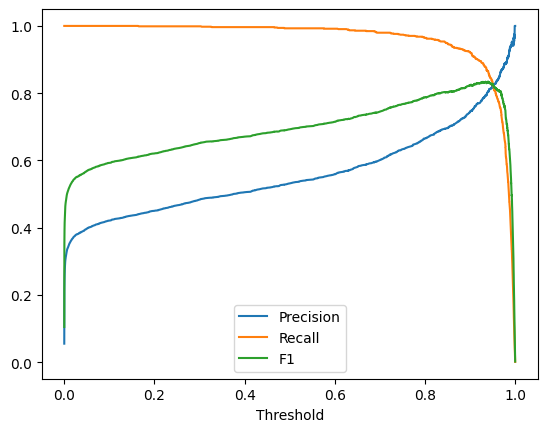

In [17]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(val_targets, val_preds)
f1_scores = 2 * (precision * recall) / (precision + recall)

best_idx = np.argmax(f1_scores)
print("Best threshold:", thresholds[best_idx], "F1:", f1_scores[best_idx])

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1")
plt.xlabel("Threshold")
plt.legend()
plt.show()


## Visualize the Model Architecture

In [18]:
print(model)

CandidateNet(
  (embeddings): ModuleDict(
    (spg_number): Embedding(214, 50)
    (func): Embedding(2, 1)
    (dimensionality): Embedding(8, 4)
    (typ): Embedding(2, 1)
    (crys): Embedding(8, 4)
  )
  (formula_emb): FormulaEmbedder(
    (emb): Embedding(89, 32)
  )
  (fc): Sequential(
    (0): Linear(in_features=111, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Discover Strange New Materials

In [28]:
import numpy as np

#threshold = 0.94  # our tuned cutoff
val_preds = np.array(val_preds)
val_targets = np.array(val_targets)

# Predicted labels at threshold
val_labels = (val_preds >= threshold).astype(int)

# False positives = predicted 1 but true 0
false_positive_indices = np.where((val_labels == 1) & (val_targets == 0))[0]

print("Number of false positives:", len(false_positive_indices))


Number of false positives: 150


In [30]:
# We assume val_loader is built from a DataFrame df_val with an index
false_positive_materials = df.iloc[false_positive_indices]

print(false_positive_materials.head())


             jid spg_number  spg_symbol  formula  formation_energy_peratom  \
88   JVASP-18433        166        R-3m   LiNiO2                  -1.44752   
187  JVASP-52783          4        P2_1  LiMnPO4                  -2.18809   
191  JVASP-91848         65        Cmmm  LaFe5H2                  -0.04638   
286  JVASP-50760         19  P2_12_12_1   LiAgF2                  -2.06912   
291  JVASP-37104        216       F-43m  Sc2MnGe                  -0.19439   

          func  optb88vdw_bandgap  \
88   OptB88vdW              0.000   
187  OptB88vdW              2.226   
191  OptB88vdW              0.000   
286  OptB88vdW              1.584   
291  OptB88vdW              0.000   

                                                 atoms   slme  magmom_oszicar  \
88   {'lattice_mat': [[2.7589489068476176, -0.00225...  16.07           1.000   
187  {'lattice_mat': [[0.0, 7.8418461397883, 0.1180...   5.84           0.000   
191  {'lattice_mat': [[4.110215016104089, 0.0, 0.0]...   5.84    

In [37]:

# Use tuned threshold
#threshold = 0.94  

val_preds = np.array(val_preds)
val_targets = np.array(val_targets)

# Predicted labels
val_labels = (val_preds >= threshold).astype(int)

# False positives = predicted 1 but true 0
false_positive_indices = np.where((val_labels == 1) & (val_targets == 0))[0]

# Build a DataFrame with formulas and probabilities
# Assuming your validation dataset has a DataFrame df_val with a 'formula' column
false_positive_df = pd.DataFrame({
    "formula": df.iloc[false_positive_indices]["formula"].values,
    "probability": val_preds[false_positive_indices]
})

# Sort by probability descending
false_positive_df = false_positive_df.sort_values(by="probability", ascending=False)

# Show top candidates
print(false_positive_df.head(20))


         formula  probability
72         Dy2Au     0.998359
41       BaNiRu2     0.998166
145       Tm2S2O     0.998140
82        Th3Pt5     0.997626
121       DyAlGe     0.997372
10            Sr     0.997027
71       ScB2Ir3     0.995693
93     Sr2CuClO2     0.995380
148       Mn3VP4     0.995211
20       SeBr6N2     0.994843
113      RbCaMg6     0.994330
117      LiTaBe2     0.992721
77        YAlPd2     0.992541
138       BeMo4W     0.992484
120      Be2SiMo     0.990752
131    Mo3WSe4S4     0.990640
28   Sr2Sc2B4O11     0.989893
116       Be2GeP     0.989539
1        LiMnPO4     0.989456
9        Ba4TaSn     0.989415


Observations:
Dy2Au, BaNiRu2, Tm2S2O, Th3Pt5 are all above 0.997: extremely strong signals.

These are a mix of binary intermetallics (Dy2Au, DyAlGe, Th3Pt5), ternary/quaternary compounds (BaNiRu2, Mn3VP4, Sr2CuClO2), and oxides/halides (Tm2S2O, SeBr6N2).

Some are simple elements or binaries (Sr, LiMnPO4), which is surprising: the model is flagging them as "positive‑like" even though they’re well‑known.
This could mean our dataset's labeling scheme treats them as negatives, but the model sees structural/feature similarity to positives.